In [1]:
import numpy as np
from Models import diffusion_advection
from scipy.optimize import least_squares
from Simulation import simulate
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.stats import loguniform

In [2]:
# Fast model using njit
# Model code to run 
import numpy as np
from collections import namedtuple

params = namedtuple('params', ["b_u", "b_l", "g", "c", "d", "p_u", "p_l", "gamma", "k", "f", "r", "D", "a"])
def model(y, t, p):
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    p = params(*p)
    dydt = np.zeros(len(y)) + 0.0
    #dSu/dt = beta_u*Su*Vu
    dydt[0] = - p.b_u*y[0]*y[3]
    #dEu/dt = beta_u*Su*Vu - g*Eu
    dydt[1] = p.b_u*y[0]*y[3] - p.g*y[1]
    #dIu/dt = g*Eu - d*Iu
    dydt[2] = p.g*y[1] - p.d*y[2]
    #dVu/dt = p_u*Iu - c*Vu - gamma*beta_u*Su*Vu - D*(Vu-Vl) + a*Vl
    dydt[3] = p.p_u*y[2] - p.c*y[3] - p.gamma*p.b_u*y[0]*y[3] - p.D*(y[3]-y[7]) + p.a*y[7]
    #dSl/dt = -beta_l*Sl*Vl
    dydt[4] = - p.b_l*y[4]*y[7]
    #dEl/dt = beta_l*Sl*Vl - g*El
    dydt[5] = p.b_l*y[4]*y[7] - p.g*y[5]
    #dIl/dt = g*El - d*Il
    dydt[6] = p.g*y[5] - p.d*y[6]
    #dVl/dt = p_l*Il - c*Vl - gamma*beta_l*Sl*Il - k*Vl*X + D*(Vu-Vl) - a*Vl
    dydt[7] = p.p_l*y[6] - p.c*y[7] - p.gamma*p.b_l*y[4]*y[7] - p.k*y[7]*y[8] + p.D*(y[3]-y[7]) - p.a*y[7]
    #dX/dt = f*Vl + r*X
    dydt[8] = p.f*y[7] + p.r*y[8]
    return dydt

In [3]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
p = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/(Cell_Count_U), 5e7/(Cell_Count_L), 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]

In [12]:
def log_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
    ts = np.linspace(0,15,1501)
    x = 100 * (np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5)
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,  7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)

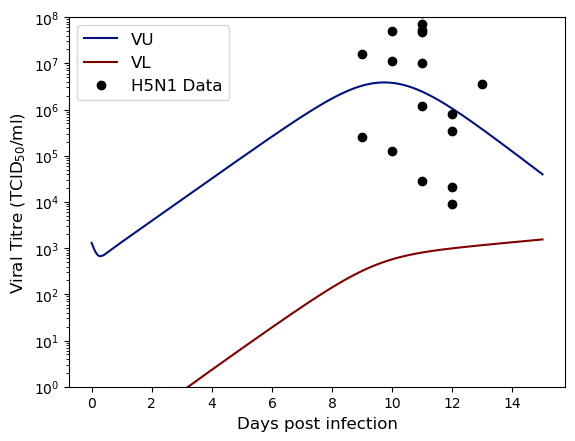

Objective: 76.55358618278868
Parameters: [1.87013351e-07 2.21084955e-06 5.23642842e-01 1.39966198e-01
 2.52022888e-02 7.85797419e-03 1.50147116e-01]


In [13]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-5,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 15, 1501)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

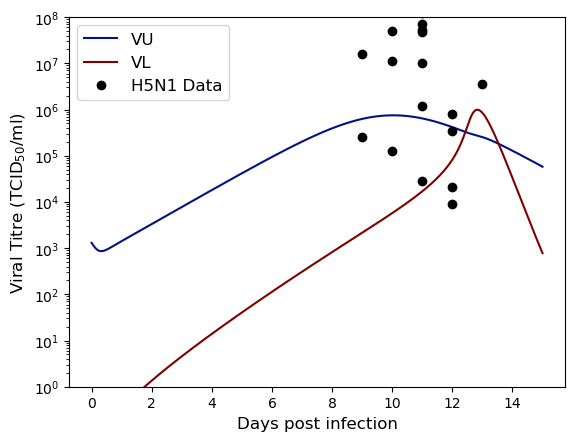

Objective: 101.50092822352507
Parameters: [4.63095897e-07 2.14451522e-05 1.22516771e-01 9.35089381e-03
 1.23902253e-03 1.04161520e-02 8.89242901e-02]


In [16]:
testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
# testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-3,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 15, 1501)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

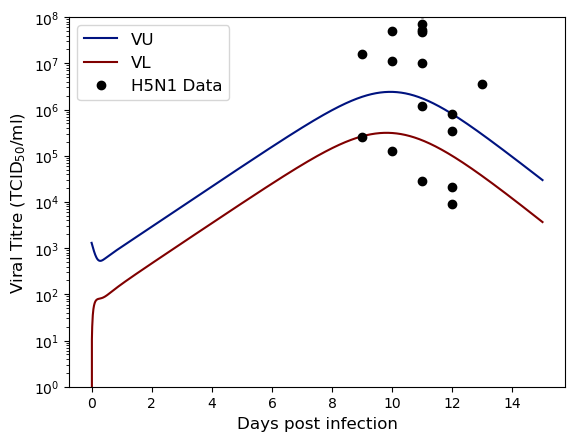

Objective: 80.07715332699236
Parameters: [2.52500428e-07 1.60657485e-08 4.80533793e-01 1.23356256e-01
 2.58283660e-02 8.59113007e-01 4.65837593e-01]


In [17]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-3,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 15, 1501)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

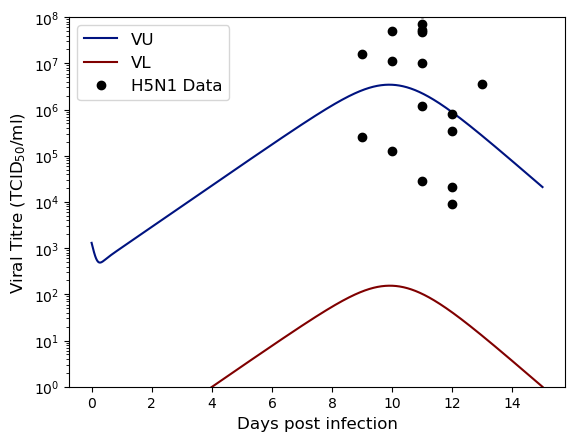

Objective: 76.5837943190234
Parameters: [2.74413800e-07 1.99960334e-06 5.07610261e-01 1.00055759e-02
 3.69728668e-02 1.97061990e-02 1.99242553e-02]


In [18]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.01,1e-5,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 15, 1501)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

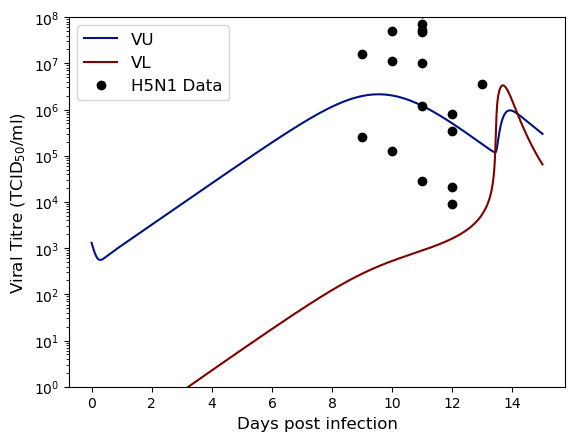

Objective: 83.66213948533634
Parameters: [2.40521594e-07 4.14487249e-04 5.01202195e-01 9.45970861e-02
 1.79806626e-02 1.37873496e+00 4.33056486e-02]


In [19]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [2.90929150e-07,6.44959323e-05,5.88235205e-01,7.69286165e-02,1.09187352e-02,2.15409340e-01,1.94858557e-02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 15, 1501)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])+5
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")